# User Experience Analysis Pt. 2


---

# Contributors

Kristina C.

Erin Costolo

Sujata Sahoo

Roger Vieira

<br>



# Objective

The objective of this notebook is to help admins and stakeholders track trends about what brings people to Underdog Devs. We will analyze text responses from applicants and mentees. A previous analysis looked at only single word tokens and did not incorporate the context of other words in the response. We will be performing Natural Language Processing (NLP) by looking at individual words, phrases, and non-consecutive words based on their frequencies in a response. We will also explore topic modeling by performing Latent Dirichlet Allocation (LDA).

<br>

# Imports


In [ ]:
# Only run this cell once, then restart runtime
!wget https://gist.githubusercontent.com/rogerfvieira/8c5187cc7d080119202d4a069d28f50c/raw/22627ca804d64360a97db9839adccacf53cdb1ef/requirements.txt
!pip install -r requirements.txt

In [ ]:
# Base
from collections import Counter, OrderedDict
import json
import requests
import re

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import altair as alt
import pandas as pd

# NLP Libraries
import spacy

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

# Load data from API

In [3]:
mongo_cursor = requests.post('http://underdog-devs-ds-a-dev.us-east-1.elasticbeanstalk.com/Responses/read').json()
responses = [obj["text"] for obj in mongo_cursor['result']]

# Lemmatization\Tokenization

In [4]:
def lemmatize(document):
    """
    Takes document (individual response) and returns list of tokens in the form
    of lemmas.
    Converts all text to lowercase tokens, removes stop words, punctuation, 
    numbers, and tokens of blank space"
    """
    
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(document)
   
    lemma_list = [
        token.lemma_.lower() for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.like_num
        and not token.is_space
    ]
    return lemma_list

In [8]:
lemmas = [lemmatize(sentences) for sentences in responses]

In [9]:
lemmas[:5]

[['mentorship', 'tuning', 'skill', 'point', 'employable'],
 ['competent', 'coder', 'start', 'successful', 'career'],
 ['well', 'developer', 'help', 'return'],
 ['network', 'well', 'opportunity'],
 ['mentorship', 'help', 'support', 'journey']]

# Frequency Analysis

## Two Word Phrases

In [10]:
double_tokens = []
for response in range(len(lemmas)):
    for token in range(len(lemmas[response]) - 1):
        double_tokens.append(lemmas[response][token] + ' ' +
                             lemmas[response][token+1])

In [11]:
freq_double = dict(Counter(double_tokens))

In [12]:
sort_freq_double = sorted(freq_double.items(), key=lambda x:x[1])

In [13]:
df_double = pd.DataFrame(sort_freq_double, columns=('phrase','frequency'))
double_top_20 = df_double[-20:]
double_top_20.tail()

,phrase,frequency
2258,software engineer,7
2259,land job,8
2260,ask question,8
2261,gain knowledge,8
2262,hope gain,18


In [14]:
double_graph = alt.Chart(
                    double_top_20,
                    title="Top 20 Most Common Phrases in User Responses"
                    ).mark_bar().encode(
                        x=alt.X("frequency:Q",
                                title='Frequency'),
                        y=alt.Y("phrase:O",
                                title='Phrases',
                                sort="-x",
                                scale=alt.Scale()
                                ))
double_graph.display()

alt.Chart(...)

## Three Word Phrases

In [15]:
triple_tokens = []
for response in range(len(lemmas)):
    for j in range(len(lemmas[response]) - 2):
        triple_tokens.append(lemmas[response][j] + ' ' +
                                 lemmas[response][j+1] + ' ' +
                                 lemmas[response][j+2])

In [16]:
freq_triple = dict(Counter(triple_tokens))

In [17]:
sort_freq_triple = sorted(freq_triple.items(), key=lambda x:x[1])

In [18]:
df_triple = pd.DataFrame(sort_freq_triple, columns=('phrase','frequency'))
triple_top_20 = df_triple[-20:]
triple_top_20.tail()

,phrase,frequency
2240,well understanding stack,2
2241,new direction life,3
2242,direction life financial,3
2243,life financial stability,3
2244,hope gain knowledge,3


In [19]:
triple_graph = alt.Chart(
                    triple_top_20,
                    title="Top 20 Most Common Phrases in User Responses"
                    ).mark_bar().encode(
                        x=alt.X("frequency:Q",
                                title='Frequency',
                                axis=alt.Axis(tickMinStep=1)
                                ),
                        y=alt.Y("phrase:O",
                                title='Phrases',
                                sort="-x")
                                )
triple_graph.display()

alt.Chart(...)

# More Data Exploration

In [20]:
# view all 3 word phrases that appear more than once across all docs
freq3_2 = {key:value for (key,value) in freq_triple.items() if value > 1}
freq3_2

{'career software developer': 2,
 'computer skill network': 2,
 'direction life financial': 3,
 'far code journey': 2,
 'gain skill need': 2,
 'gain well understanding': 2,
 'help foot door': 2,
 'help learn code': 2,
 'high pay job': 2,
 'hope gain knowledge': 3,
 'hope gain mentor': 2,
 'job software development': 2,
 'learn new skill': 2,
 'life financial stability': 3,
 'like minded individual': 2,
 'network build confidence': 2,
 'new direction life': 3,
 'people similar situation': 2,
 'self teach developer': 2,
 'skill land job': 2,
 'skill network build': 2,
 'well understanding stack': 2}

## Two Nonconsecutive Tokens From Responses
Frequency analysis on any two words in one response, not only consequetive ones.


In [21]:
two_tokens = []
for i in range(len(lemmas)):
    for j in range(len(lemmas[i]) - 1):
        for k in range(j + 1, len(lemmas[i])):
            new = sorted([lemmas[i][j], lemmas[i][k]])
            two_tokens.append(new[0] + ' ' +  new[1])

In [22]:
freq_two = dict(Counter(two_tokens))

In [23]:
sort_freq_two = sorted(freq_two.items(), key=lambda x:x[1])
sort_freq_two[-20:]

[('community learn', 15),
 ('like mentor', 15),
 ('hope job', 16),
 ('community people', 16),
 ('hope skill', 17),
 ('job mentor', 17),
 ('learn skill', 17),
 ('good learn', 17),
 ('learn people', 18),
 ('help skill', 19),
 ('help want', 20),
 ('learn like', 21),
 ('like people', 21),
 ('help people', 21),
 ('job learn', 22),
 ('help job', 24),
 ('help learn', 26),
 ('job skill', 27),
 ('gain hope', 27),
 ('help like', 33)]

## Three Nonconsecutive Tokens

In [24]:
three_tokens = []
for i in range(len(lemmas)):
    for j in range(len(lemmas[i]) - 2):
        for k in range(j + 1, len(lemmas[i]) - 1):
            for l in range(k + 1, len(lemmas[i])):
                new = sorted([lemmas[i][j], lemmas[i][k], lemmas[i][l]])
                three_tokens.append(new[0] + ' ' +  new[1] + ' ' + new[2])

In [25]:
freq_three = dict(Counter(three_tokens))

In [26]:
sort_freq_three = sorted(freq_three.items(), key=lambda x:x[1])
sort_freq_three[-20:]

[('help race want', 18),
 ('experience help people', 19),
 ('experience job people', 19),
 ('good help learn', 19),
 ('people situation understand', 19),
 ('like people situation', 19),
 ('like people understand', 19),
 ('like understanding well', 20),
 ('help understanding well', 20),
 ('help learn like', 22),
 ('hard learn people', 24),
 ('good learn people', 24),
 ('learn people understand', 24),
 ('experience learn people', 25),
 ('learn people situation', 25),
 ('help learn people', 25),
 ('learn like people', 25),
 ('job learn people', 25),
 ('help like people', 27),
 ('bear race want', 27)]

# Topic modeling and LDA:
Topic modeling allows the user to explore the content of the documents and build new connections between topics they might not have been aware of. Latent Dirichlet Allocation (LDA) is a type of topic modeling in which words are represented as topics, and documents are represented as a collection of these word topics.
 	A useful topic model has big non-overlapping circles scattered throughout the chart instead of being clustered in one quadrant. The package also allows the user to observe the most relevant keywords from the selected topic.

## A Latent Dirichlet Allocation(LDA) Model with gensim


**The two main inputs to the genesim LDA topic model are the dictionary(id2word) and the corpus.**



*   The id2word is a special object that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text.
*   The corpus is a specially formatted list containing information about each document.




**Create the id2word dictionary**




In [27]:
id2word = corpora.Dictionary(lemmas)

In [28]:
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in lemmas]

In [29]:
n_of_words = [len(lemmas[i]) for i in range(len(lemmas))]
sorted(n_of_words)[-10:]

[31, 32, 33, 37, 38, 38, 43, 54, 57, 93]

### Train an LDA model

In [ ]:
num_topics = 3

lda_multicore_3_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=1, 
                                                        random_state=1234, 
                                                        iterations=10) 

### Interpretion of LDA results and Selection of the appropriate number of topics


*   LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation(LDA)




### Visualising the topics in the model

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore_3_topics, corpus, id2word)
vis

In [ ]:
num_topics = 5

lda_multicore_5_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=1, 
                                                        random_state=1234, 
                                                        iterations=10) 

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore_5_topics, corpus, id2word)
vis

### Coherence Measures


Coherence score in topic modeling measures how similar topic words are to each other. Usually, the coherence score increases with the increase in the number of topics. This increase becomes smaller as the number of topics gets higher. The best choice is a point after which the increase in coherence score is no longer worth the additional increase in the number of topics. 

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit=None, start=None, step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmas, start=2, limit=10, step=1)

### Plot the coherence scores vs number of topics

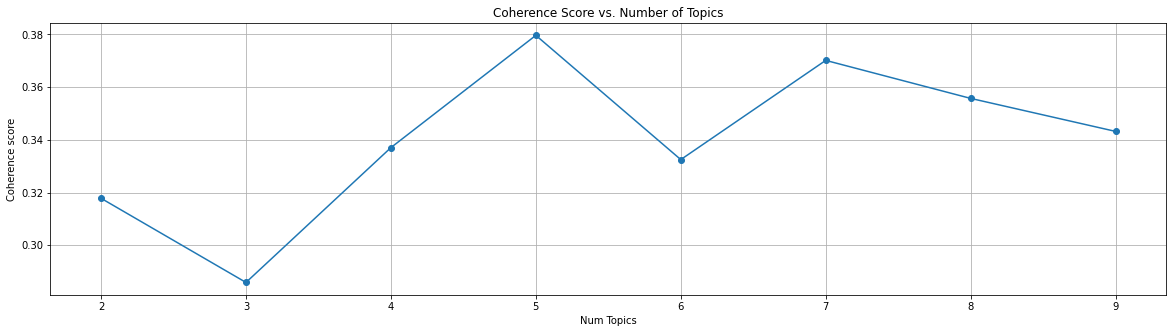

In [36]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [ ]:
num_topics = 7

lda_multicore_7_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=1, 
                                                        random_state=1234, 
                                                        iterations=10) 

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore_7_topics, corpus, id2word)
vis

## Limitations of LDA:

There are a few limitations to LDA:
- The number of topics is fixed and must be known ahead of time.
- LDA is unable to represent correlations that provide uncorrelated topics across the documents.
- LDA is unsupervised.
- LDA presumes words are exchangeable and does not account for sentence structure or multiple-word phrases.
- LDA performs better for larger texts and is not very suitable for texts with less than 50 words.


# Conclusions

### Frequency Analysis
In our specific model, we worked with mock data collected by answering the question: “What are the applicants and mentees hoping to gain from the community?” Through our analysis, we found the most inherently useful graphic to be the chart of two-word token frequencies. For now, this will be the only chart we share with administrators once we create an endpoint, but new trends will likely arise with real data. The three-word tokens may then become more useful for informing admins about what the users want to gain from the community.


### Topic Modelling
We built the LDA model and visualized results using the pyLDAvis package. Since our coherence score peaked at num_topics = 5, we tried several different numbers of topics (3, 5, 7), but none of them showed useful topic distribution. Mostly, all the topics used the same common words but with slightly different frequencies. This result is not surprising, since there is a clear objective (topic) why the underdog-devs project was created. Moreover, LDA is not the best fit for our collection, since we worked with short texts (only 3 responses out of 335 are longer than 50 words).